<div style='background-color:#fff87e;border:2px solid black;border-radius:20px;padding:10px;'>
    
<h1>Covid Data Analysis</h1>
   
For business inquiries or collaboration requests, you can reach me at <span style="font-weight: bold; color: black;">peige77@gmail.com</span>

This large data set contains data on covid statistics from around the world, the data set can be found in the files section of this repo or downloaded directly from <a style='font-weight:bold;' href='https://ourworldindata.org/covid-deaths'>ourworldindata.org</a>

**Tools & Software utilized:**
- Microsoft SQL Server Management Studio (ELT, extract, load, transform)
- Python with JupyterLab (final minipulation and visualization)

**Project structure:**
- Project Objectives & Goals
- Data Collection, Extraction and Transformation
- Exploratory Data Analysis
- Conclusions
</div>

<div style='background-color: #00296b; color: #ffffff; border-radius: 10px; border: 2px solid black; padding: 10px;'>
<h2>Project Objectives & Goals</h2>
    <ul>
        <li>Identify the continent with the most covid deaths</li>
        <li>Identify the continent with the highest mortality rate</li>
        <li>Track new cases per day for duration of data set</li>
    </ul>
</div>

<div style='background-color: #00296b; color: #ffffff; border-radius: 10px; border: 2px solid black; padding: 10px;'>
<h2>Data Collection, Extraction and Transformation</h2>
</div>

<h4>Queries ran in Microsoft SQL Server Management Studio</h4>

```sql
--Ensuring our tables imported correctly
--covid_deaths table
SELECT *
FROM [Covid Project].dbo.covid_deaths
WHERE continent is not NULL
ORDER BY 3,4;

--covid_vac table
SELECT *
FROM [Covid Project].dbo.covid_vac
ORDER BY 3,4

--Filtering our data by desired columns
SELECT Location,Date, total_cases, new_cases, total_deaths, population
FROM [Covid Project].dbo.covid_deaths
ORDER BY 1,2

--Converting data types to floats
ALTER TABLE [Covid Project]..covid_deaths
ALTER COLUMN total_deaths FLOAT;
ALTER TABLE [Covid Project]..covid_deaths
ALTER COLUMN total_cases FLOAT;


--Adding a mortality_rate column to our covid_deaths table
Alter Table [Covid Project]..covid_deaths
add mortality_rate as ((total_deaths/total_cases)*100);

--Executing a query to observe our new column
SELECT Location, Date, total_cases, total_deaths, mortality_rate
FROM [Covid Project].dbo.covid_deaths
ORDER BY 1, 2;

--Identifying mortality_rate in the US
SELECT Location,Date, total_cases,total_deaths, mortality_rate
INTO [Covid Project].dbo.US_mortality_rate
FROM [Covid Project].dbo.covid_deaths
WHERE LOCATION like '%states%'
ORDER BY 1,2

-- total_cases vs. population
ALTER TABLE [Covid Project]..covid_deaths
add infection_rate as (total_cases/population)*100;

--Percentage of people living in the US who have been infected with Covid
SELECT location, date,total_cases,population, infection_rate
FROM [Covid Project]..covid_deaths
Where location LIKE 'United States'
ORDER BY 1,2

--Identifying the countries with the highest number of infections and ordering data by percent_of_pop_infected
SELECT location,population, MAX(infection_rate)as percent_of_pop_infected,MAX(total_cases) as number_of_infection
FROM [Covid Project]..covid_deaths
GROUP BY population, location
ORDER BY percent_of_pop_infected DESC

--Calculating the total number of covid deaths in each country
SELECT location, population, MAX(total_deaths) AS max_total_deaths
FROM [Covid Project]..covid_deaths
WHERE continent IS NOT NULL
GROUP BY location, population
ORDER BY max_total_deaths DESC;

--Figuring out the percent of the total population of each country that passed away due to covid
SELECT location, population, MAX(total_deaths), ((MAX(total_deaths)/population)*100) as percent_of_pop_deaths
FROM [Covid Project].dbo.covid_deaths
WHERE continent IS NOT NULL
GROUP BY Location,population
ORDER BY percent_of_pop_deaths desc

--Breaking down deaths by continent
SELECT location,MAX(population) as max_pop, MAX(total_deaths) as max_deaths, MAX(total_deaths)/MAX(population)*100 as percent_pop_deaths
INTO [Covid Project]..death_by_continent
FROM [Covid Project].dbo.covid_deaths
WHERE continent IS NULL
GROUP BY location
ORDER BY percent_pop_deaths desc

--Number of new_cases of covid per day globally and number of new_death per day globally
SELECT date,SUM(new_cases) AS new_cases_per_day,SUM(new_deaths) AS new_deaths_per_day,
    CASE WHEN SUM(new_cases) = 0 THEN NULL
         ELSE SUM(new_deaths) / SUM(new_cases) * 100
    END AS daily_mortality_rate
INTO [Covid Project]..new_cases_per_day_globally
FROM [Covid Project]..covid_deaths
WHERE continent IS NULL
GROUP BY date
ORDER BY date;

--Global statistics for new_cases, new_deaths and daily_mortality_rate
SELECT SUM(new_cases) AS new_cases_per_day,SUM(new_deaths) AS new_deaths_per_day,
    CASE WHEN SUM(new_cases) = 0 THEN NULL
         ELSE SUM(new_deaths) / SUM(new_cases) * 100
    END AS daily_mortality_rate
FROM [Covid Project]..covid_deaths
WHERE continent IS NULL

--Joining our two tables to perform further queries
SELECT *
FROM [Covid Project]..covid_deaths as death
join [Covid Project]..covid_vac as vac
on death.location = vac.location and death.date = vac.date

--Determining the number of new_vaccinations per day
SELECT death.continent,death.location, death.date, death.population, vac.new_vaccinations,
SUM(Cast(vac.new_vaccinations as FLOAT)) OVER(PARTITION BY death.location ORDER BY death.location, death.date) as running_vaccine_total
FROM [Covid Project]..covid_deaths as death
join [Covid Project]..covid_vac as vac
on death.location = vac.location and death.date = vac.date
WHERE death.continent IS NULL
ORDER BY 1,2,3

--Determining the number of new_vaccinations per day
WITH popvsvac (continent, location,date,population, new_vaccinations, running_vaccine_total)
AS
(
SELECT death.continent,death.location, death.date, death.population, vac.new_vaccinations,
SUM(Cast(vac.new_vaccinations as FLOAT)) OVER(PARTITION BY death.location ORDER BY death.location, death.date) as running_vaccine_total
FROM [Covid Project]..covid_deaths as death
join [Covid Project]..covid_vac as vac
on death.location = vac.location and death.date = vac.date
WHERE death.continent IS NOT NULL
and death.location like 'UNITED STATES'
)
SELECT *, running_vaccine_total/population*100 as percent_of_pop_vaccinated
FROM popvsvac

-- Identifying every continent present in our data
SELECT DISTINCT continent
FROM [Covid Project]..covid_deaths

-- Creating table for future visualizations 
DROP TABLE if exists [Covid Project].dbo.viz
CREATE TABLE [Covid Project].dbo.viz(
continent varchar(255),
location varchar(255),
date datetime,
population numeric,
new_vaccinations numeric,
running_vaccine_total numeric)
INSERT INTO [Covid Project].dbo.viz
SELECT death.continent,death.location, death.date, death.population, vac.new_vaccinations,
SUM(Cast(vac.new_vaccinations as FLOAT)) OVER(PARTITION BY death.location ORDER BY death.location, death.date) as running_vaccine_total
FROM [Covid Project]..covid_deaths as death
join [Covid Project]..covid_vac as vac
on death.location = vac.location and death.date = vac.date
WHERE death.continent IS NULL
and death.location IN ('North America', 'Asia', 'Africa', 'South America', 'Europe');
SELECT *, running_vaccine_total/population*100 as percent_of_pop_vaccinated
FROM [Covid Project].dbo.viz

--Creating a table for python map viz in jupyter
-- population, continent, total_deaths, new_cases, new_vaccinations, location

--Creating a new table for coordinates of each location
CREATE TABLE [Covid Project].dbo.coordinates(
    location VARCHAR(255) PRIMARY KEY,
    latitude DECIMAL(9, 6),
    longitude DECIMAL(9, 6)
);
INSERT INTO [Covid Project].dbo.coordinates (location, latitude, longitude)
VALUES
    ('Oceania', -25.2744, 133.7751),
    ('South America', -14.2350, -51.9253),
    ('European Union', 51.1657, 10.4515),
    ('North America', 54.5260, -105.2551),
    ('Low income', 0.0, 0.0), 
    ('Europe', 54.5260, 15.2551),
    ('High income', 0.0, 0.0),
    ('Africa', -8.7832, 34.5085),
    ('Upper middle income', 0.0, 0.0), 
    ('Lower middle income', 0.0, 0.0), 
    ('Asia', 34.0479, 100.6197),
    ('World', 0.0, 0.0); 

--Joining our new table and creating a new table by combining: deaths, vac and coordinates
SELECT death.continent, death.location, death.population, MAX(death.total_deaths) AS max_total_deaths, 
MAX(death.new_cases) AS max_new_cases, MAX(vac.new_vaccinations) AS max_new_vaccinations, coord.latitude, coord.longitude
INTO [Covid Project]..mapdf
FROM [Covid Project]..covid_deaths AS death
JOIN [Covid Project]..covid_vac AS vac
ON death.location = vac.location AND death.date = vac.date
JOIN [Covid Project]..coordinates AS coord
ON death.location = coord.location
WHERE death.continent IS NULL
GROUP BY death.continent, death.location, death.population, coord.latitude, coord.longitude;
```

In [249]:
!pip install folium

In [250]:
# Import necessary python libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sci

In [251]:
# Creating our data frame for further analysis
us_mortality_rate = pd.read_csv(r"C:\Users\PM\Desktop\Data Analytics Projects\Covid SQL\US_mortality_rate_per_day.csv")
mapdf = pd.read_csv(r"C:\Users\PM\Desktop\Data Analytics Projects\Covid SQL\mapdf_with_coordinates.csv")
global_cases = pd.read_csv(r"C:\Users\PM\Desktop\Data Analytics Projects\Covid SQL\global_cases.csv")
death_continent = pd.read_csv(r"C:\Users\PM\Desktop\Data Analytics Projects\Covid SQL\deaths_by_continent.csv")

<div style='background-color: #00296b; color: #ffffff; border-radius: 10px; border: 2px solid black; padding: 10px;'>
<h2>Exploratory Data Analysis</h2>
</div>

In [252]:
us_mortality_rate.head()

,Location,Date,total_cases,total_deaths,mortality_rate
0,United States,2020-01-03 00:00:00.000,NaN,NaN,NaN
1,United States,2020-01-04 00:00:00.000,NaN,NaN,NaN
2,United States,2020-01-05 00:00:00.000,NaN,NaN,NaN
3,United States,2020-01-06 00:00:00.000,NaN,NaN,NaN
4,United States,2020-01-07 00:00:00.000,NaN,NaN,NaN


In [253]:
us_mortality_rate.describe()

,total_cases,total_deaths,mortality_rate
count,9.830000e+02,9.430000e+02,943.000000
mean,3.771351e+07,5.682912e+05,2.171284
std,3.135843e+07,3.368697e+05,1.300534
min,1.000000e+00,1.000000e+00,1.103282
25%,6.855728e+06,2.251295e+05,1.230104
50%,3.279536e+07,5.966660e+05,1.762479
75%,7.111670e+07,8.964115e+05,2.305261
max,9.485211e+07,1.046486e+06,6.131883


In [254]:
us_mortality_rate.shape

(1000, 5)

In [255]:
#After attempting to make data viz with this data, I determined that we should alter
#the dataframe to make the viz less busy and more readible

us_mortality_rate['Date'] = pd.to_datetime(us_mortality_rate['Date'])

grouped_data = us_mortality_rate.groupby([us_mortality_rate['Date'].dt.year, us_mortality_rate['Date'].dt.month], as_index=False)

grouped_data = grouped_data.agg({
    'Location': 'first',  
    'Date':'first',
    'total_cases': 'sum',
    'total_deaths': 'sum',
    'mortality_rate': 'mean'
})

print(grouped_data)

         Location       Date   total_cases  total_deaths  mortality_rate
0   United States 2020-01-03  5.700000e+01           0.0             NaN
1   United States 2020-02-01  8.340000e+02           1.0        1.449275
2   United States 2020-03-01  9.902100e+05       15521.0        2.327652
3   United States 2020-04-01  1.839791e+07      923589.0        4.538078
4   United States 2020-05-01  4.461508e+07     2686498.0        6.024868
5   United States 2020-06-01  6.449967e+07     3517682.0        5.483857
6   United States 2020-07-01  1.096588e+08     4387347.0        4.066337
7   United States 2020-08-01  1.651666e+08     5402211.0        3.278734
8   United States 2020-09-01  1.987398e+08     6007226.0        3.025940
9   United States 2020-10-01  2.494278e+08     6869198.0        2.760168
10  United States 2020-11-01  3.330169e+08     7569393.0        2.292020
11  United States 2020-12-01  5.148745e+08     9716018.0        1.895089
12  United States 2021-01-01  7.158231e+08    12500

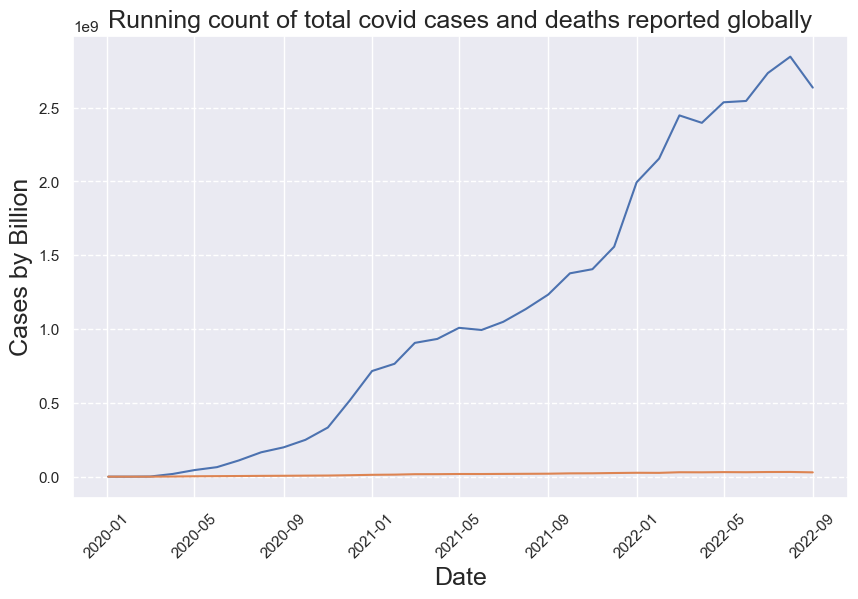

In [256]:
# Creating a line graph to visualize our 3 colmns total_cases, total_deaths & mortality_rate
plt.figure(figsize=(10, 6))
sns.set_theme(style='darkgrid')

sns.lineplot(data=grouped_data, x='Date', y='total_cases')
sns.lineplot(data=grouped_data, x='Date', y='total_deaths')

plt.xticks(rotation=45)
plt.ylabel('Cases by Billion', size=18)
plt.title('Running count of total covid cases and deaths reported globally', size=18)
plt.xlabel('Date', size=18)
plt.grid(axis='y', linestyle='--')

plt.show()

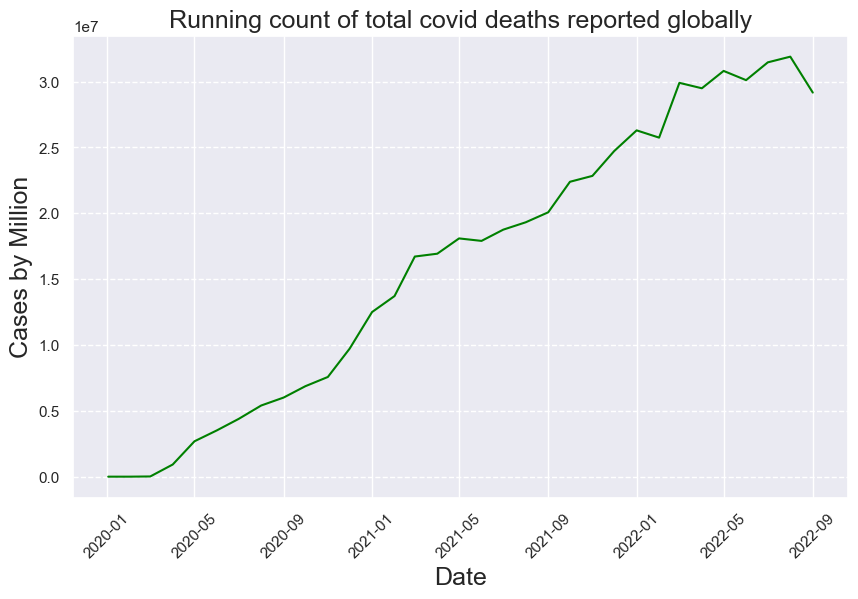

In [257]:
# viz for total covid deaths
plt.figure(figsize=(10, 6))
sns.set_theme(style='darkgrid')

sns.lineplot(data=grouped_data, x='Date', y='total_deaths', color='green')

plt.xticks(rotation=45)
plt.ylabel('Cases by Million', size=18)
plt.title('Running count of total covid deaths reported globally', size=18)
plt.xlabel('Date', size=18)
plt.grid(axis='y', linestyle='--')

plt.show()

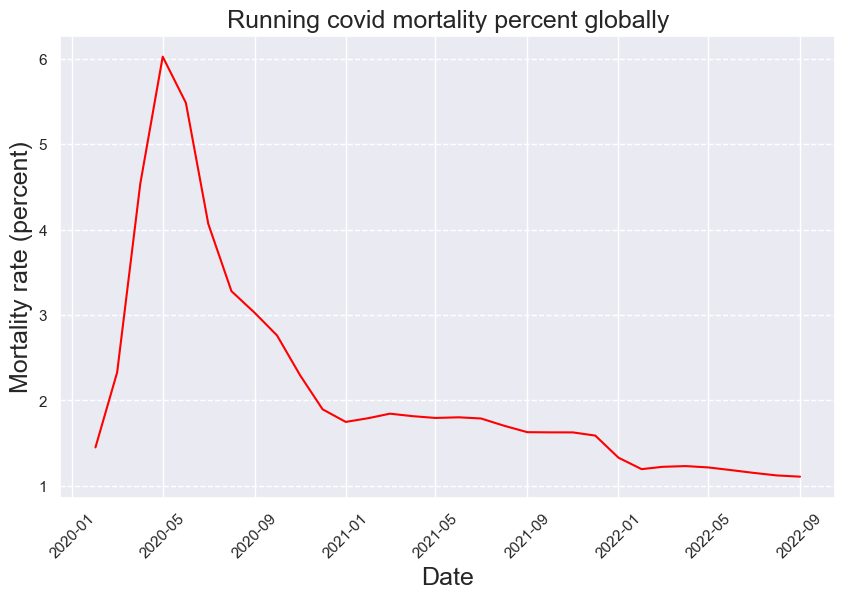

In [258]:
# Overall I am still unhappy with the viz so this will be just for mortality_rate
plt.figure(figsize=(10, 6))
sns.set_theme(style='darkgrid')

sns.lineplot(data=grouped_data, x='Date', y='mortality_rate', color='red')

plt.xticks(rotation=45)
plt.ylabel('Mortality rate (percent)', size=18)
plt.title('Running covid mortality percent globally', size=18)
plt.xlabel('Date', size=18)
plt.grid(axis='y', linestyle='--')

plt.show()

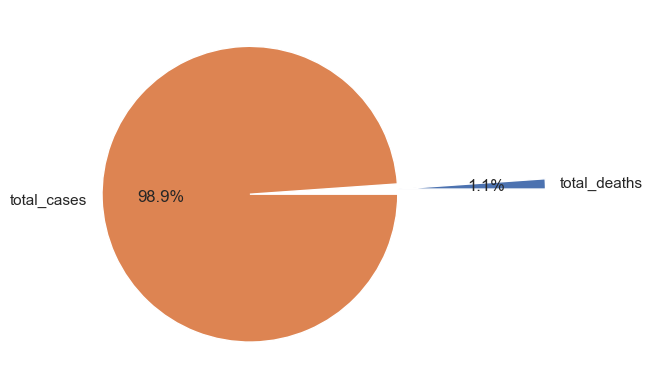

In [259]:
# total_cases vs. total_deaths pie chart 
# This chart is not very useful or accurate but I wanted to make a quick pie chart 
labels = 'total_deaths', 'total_cases'
sizes = [31890736, 28_454_630_00]

explode = (1, 0)
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')

plt.show()

In [260]:
mapdf.head(15)

,continent,location,population,max_total_deaths,max_new_cases,max_new_vaccinations,latitude,longitude
0,NaN,Africa,1426736614,259040,72463,997747,-8.7832,34.5085
1,NaN,Asia,4721383370,1635676,7213802,993935,34.0479,100.6197
2,NaN,Europe,744807803,2085294,6386449,9955,54.5260,15.2551
3,NaN,European Union,450146793,1248722,5896096,999387,51.1657,10.4515
4,NaN,High income,1250514600,2927967,7065170,999,0.0000,0.0000
5,NaN,Low income,737604900,48010,24836,98968,0.0000,0.0000
6,NaN,Lower middle income,3432097300,1340740,583428,9936760,0.0000,0.0000
7,NaN,North America,600323657,1620877,1410856,999947,54.5260,-105.2551
8,NaN,Oceania,45038860,30558,589296,9926,-25.2744,133.7751
9,NaN,South America,436816679,1353815,459421,99705,-14.2350,-51.9253


In [261]:
mapdf.shape

(12, 8)

In [262]:
# Creating a map viz for each continent
from folium.plugins import MarkerCluster

world_map = folium.Map(location=[0, 0], zoom_start=1.2)

marker_cluster = MarkerCluster().add_to(world_map)

for index, row in mapdf.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"<b>{row['location']}</b><br>Population: {row['population']}<br>Max Total Deaths: {row['max_total_deaths']}<br>Max New Cases: {row['max_new_cases']}<br>Max New Vaccinations: {row['max_new_vaccinations']}",
        icon=None,
    ).add_to(marker_cluster)

world_map

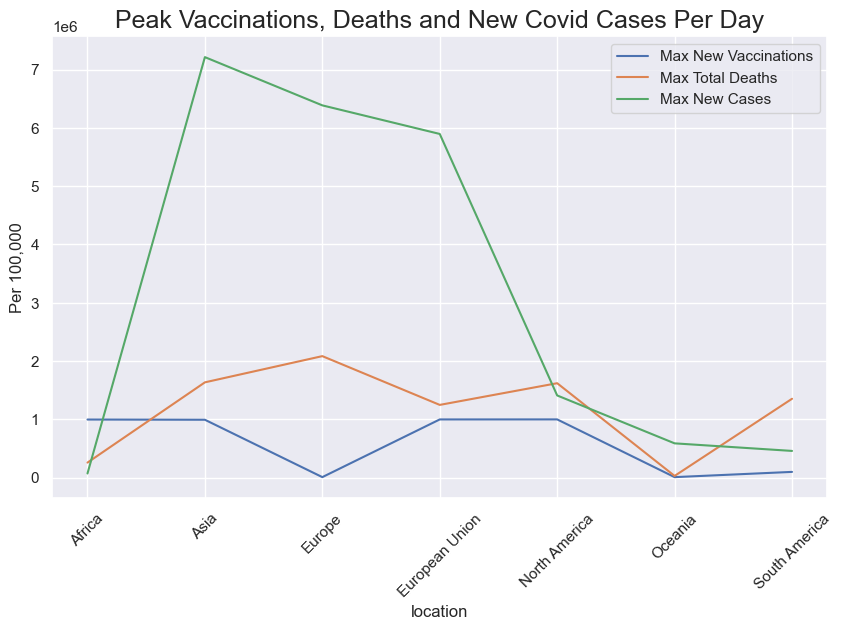

In [282]:
indices_to_drop = [6, 10, 11, 5, 4]
mapdf_dropped = mapdf.drop(indices_to_drop)

plt.figure(figsize=(10,6))

sns.lineplot(data=mapdf_dropped, x='location', y='max_new_vaccinations', label='Max New Vaccinations')
sns.lineplot(data=mapdf_dropped, x='location', y='max_total_deaths', label='Max Total Deaths')
sns.lineplot(data=mapdf_dropped, x='location', y='max_new_cases', label='Max New Cases')

plt.title("Peak Vaccinations, Deaths and New Covid Cases Per Day", size=18)
plt.ylabel('Per 100,000')
plt.xticks(rotation=45)
plt.legend()

plt.show()

In [264]:
mapdf_dropped.head(10)

,continent,location,population,max_total_deaths,max_new_cases,max_new_vaccinations,latitude,longitude
0,NaN,Africa,1426736614,259040,72463,997747,-8.7832,34.5085
1,NaN,Asia,4721383370,1635676,7213802,993935,34.0479,100.6197
2,NaN,Europe,744807803,2085294,6386449,9955,54.5260,15.2551
3,NaN,European Union,450146793,1248722,5896096,999387,51.1657,10.4515
7,NaN,North America,600323657,1620877,1410856,999947,54.5260,-105.2551
8,NaN,Oceania,45038860,30558,589296,9926,-25.2744,133.7751
9,NaN,South America,436816679,1353815,459421,99705,-14.2350,-51.9253


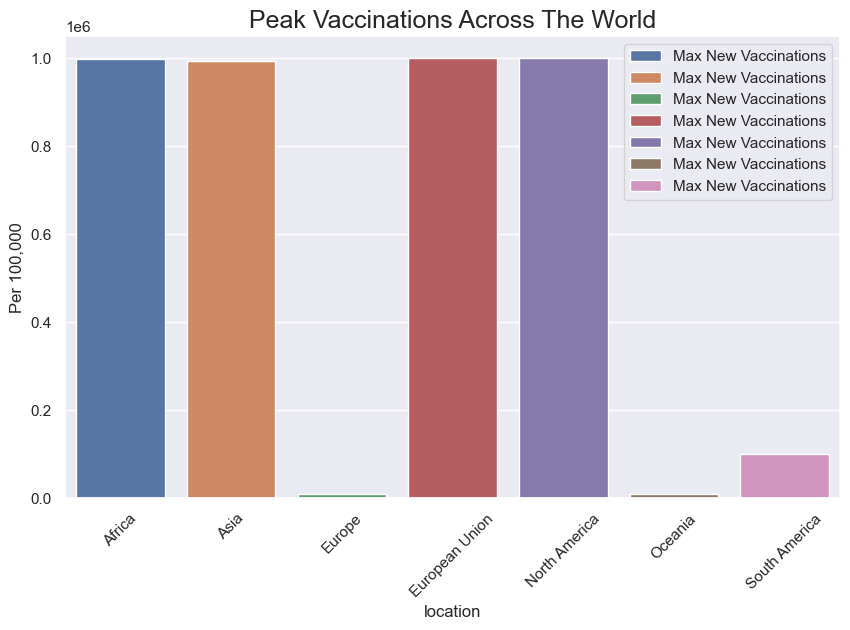

In [281]:
plt.figure(figsize=(10,6))

sns.barplot(data=mapdf_dropped, x='location', y='max_new_vaccinations', label='Max New Vaccinations', hue='location')

plt.title("Peak Vaccinations Across The World", size=18)
plt.ylabel('Per 100,000')
plt.xticks(rotation=45)
plt.legend()

plt.show()

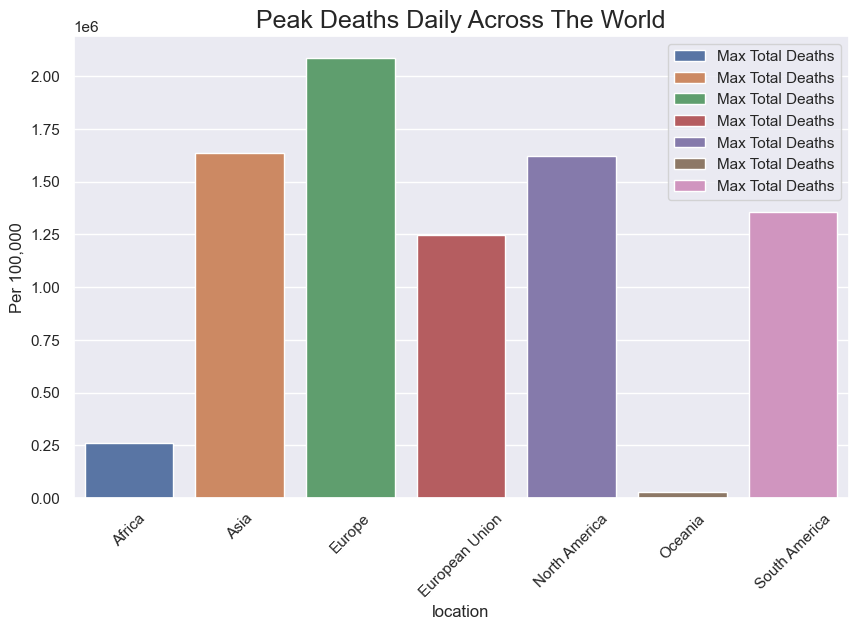

In [266]:
plt.figure(figsize=(10, 6))

sns.barplot(data=mapdf_dropped, x='location', y='max_total_deaths', label='Max Total Deaths', hue='location')

plt.title("Peak Deaths Daily Across The World", size=18)
plt.ylabel('Per 100,000')
plt.xticks(rotation=45)
plt.legend()

plt.show()

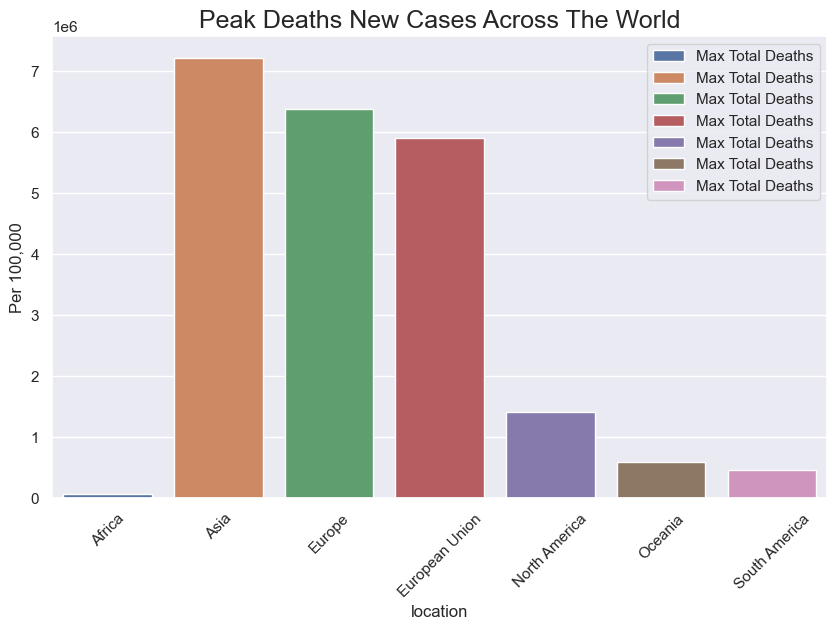

In [267]:
plt.figure(figsize=(10,6))

sns.barplot(data=mapdf_dropped, x='location', y='max_new_cases', label='Max Total Deaths', hue='location')

plt.title("Peak Deaths New Cases Across The World", size=18)
plt.ylabel('Per 100,000')
plt.xticks(rotation=45)
plt.legend()

plt.show()

In [268]:
global_cases.head()

,date,new_cases_per_day,new_deaths_per_day,daily_mortality_rate
0,2022-03-14 00:00:00.000,3600752.0,13054.0,0.362535
1,2022-05-24 00:00:00.000,842658.0,2585.0,0.306767
2,2020-07-29 00:00:00.000,672599.0,17989.0,2.674551
3,2021-04-16 00:00:00.000,2194241.0,38143.0,1.738323
4,2021-06-26 00:00:00.000,1162881.0,24859.0,2.137708


In [269]:
global_cases.shape

(1000, 4)

In [273]:
global_cases['date'] = pd.to_datetime(global_cases['date'])
global_grouped = global_cases.groupby([global_cases['date'].dt.year, global_cases['date'].dt.month], as_index=False)

global_grouped = global_grouped.agg({
    'date':'first',
    'new_cases_per_day':'sum',
    'new_deaths_per_day':'sum',
    'daily_mortality_rate':'first'
})

global_grouped.shape

(48, 4)

In [297]:
# Dropping row 1 due to it appearing as an outlier and the calculation is inaccurate
global_grouped = global_grouped.drop(1)
global_grouped.head()

,date,new_cases_per_day,new_deaths_per_day,daily_mortality_rate
0,2020-01-25,21709.0,468.0,3.382664
2,2020-03-05,1706509.0,108016.0,4.038005
3,2020-04-20,4264942.0,386314.0,7.858770
4,2020-05-30,6292837.0,368198.0,4.513724
5,2020-06-05,8404520.0,308588.0,4.399615


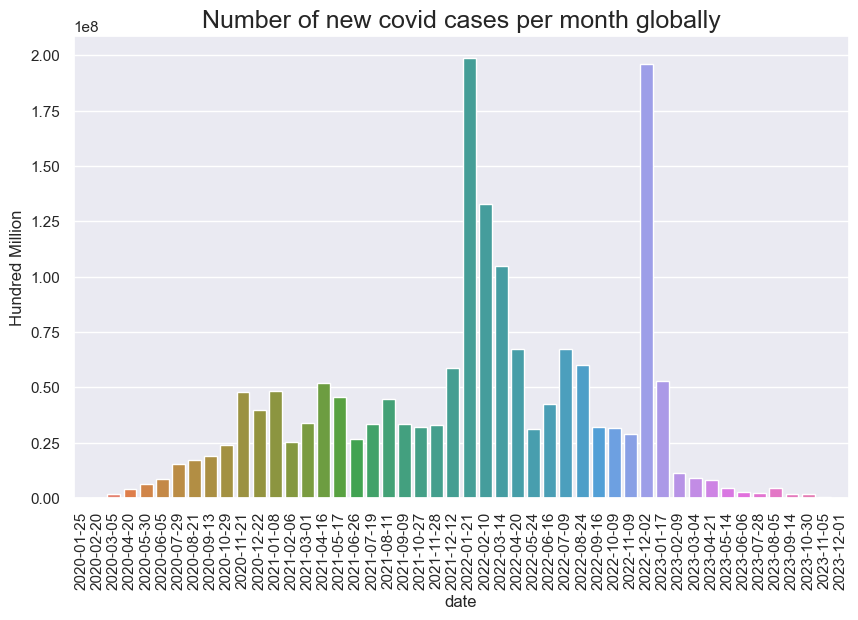

In [293]:
plt.figure(figsize=(10,6))

sns.barplot(data=global_grouped, x='date', y='new_cases_per_day', label='Daily Cases', hue='date')
plt.xticks(rotation=90)
plt.title('Number of new covid cases per month globally', size=18)
plt.ylabel('Hundred Million')
plt.show()

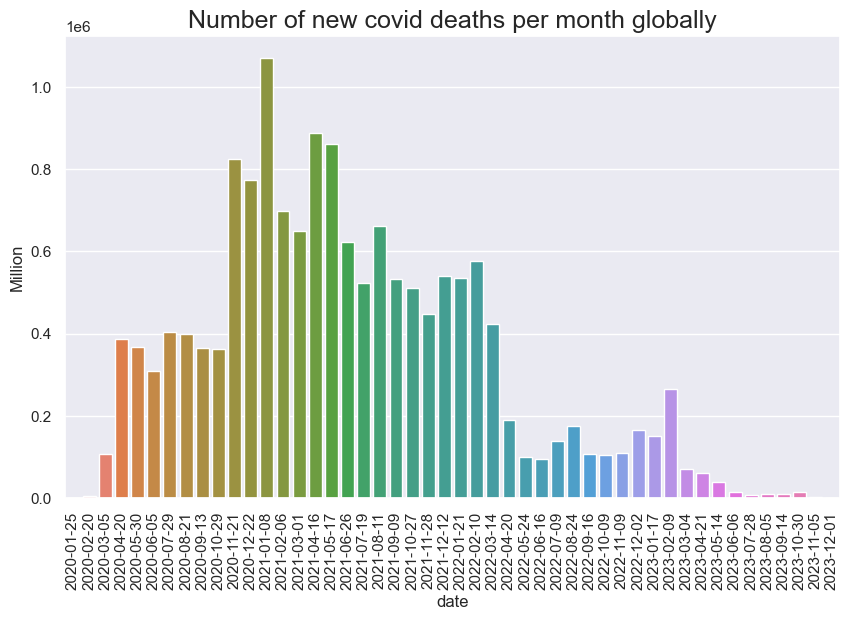

In [292]:
plt.figure(figsize=(10,6))

sns.barplot(data=global_grouped, x='date', y='new_deaths_per_day', label='Daily Cases', hue='date')
plt.xticks(rotation=90)
plt.title('Number of new covid deaths per month globally', size=18)
plt.ylabel('Million')
plt.show()

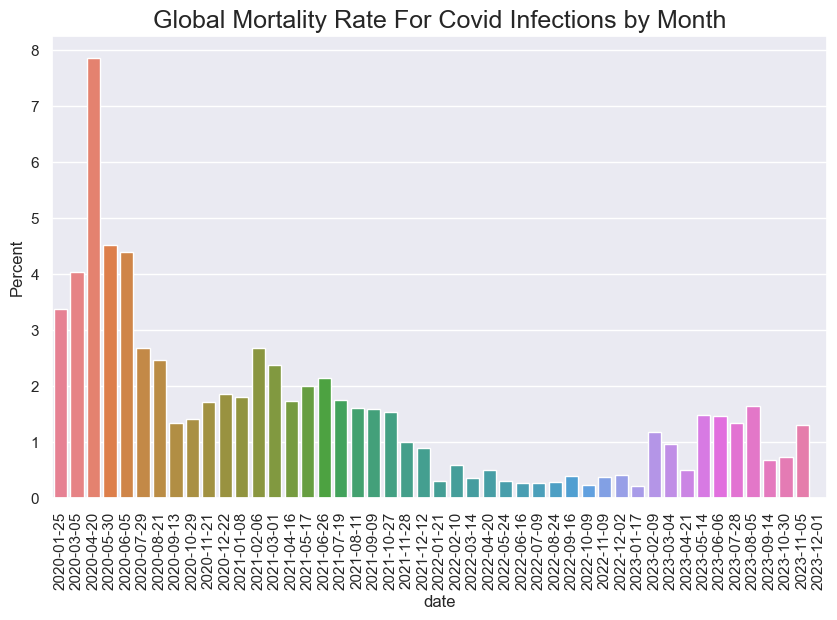

In [300]:
plt.figure(figsize=(10,6))

sns.barplot(data=global_grouped, x='date', y='daily_mortality_rate', hue='date')
plt.xticks(rotation=90)
plt.title('Global Mortality Rate For Covid Infections by Month', size=18)
plt.ylabel('Percent')
plt.show()

In [301]:
death_continent.head()

,location,max_pop,max_deaths,percent_pop_deaths
0,Lower middle income,3432097300,1340740,0.039065
1,North America,600323657,1620877,0.270001
2,Asia,4721383370,1635676,0.034644
3,World,7975105024,6985265,0.087588
4,Low income,737604900,48010,0.006509


In [307]:
death_continent = death_continent.drop([11,9,3,0,4])

In [308]:
death_continent.sort_values(by='max_deaths', ascending=False)

,location,max_pop,max_deaths,percent_pop_deaths
10,Europe,744807803,2085294,0.279977
2,Asia,4721383370,1635676,0.034644
1,North America,600323657,1620877,0.270001
8,South America,436816679,1353815,0.309927
7,European Union,450146793,1248722,0.277403
5,Africa,1426736614,259040,0.018156
6,Oceania,45038860,30558,0.067848


In [309]:
death_continent.sort_values(by='percent_pop_deaths', ascending=False)

,location,max_pop,max_deaths,percent_pop_deaths
8,South America,436816679,1353815,0.309927
10,Europe,744807803,2085294,0.279977
7,European Union,450146793,1248722,0.277403
1,North America,600323657,1620877,0.270001
6,Oceania,45038860,30558,0.067848
2,Asia,4721383370,1635676,0.034644
5,Africa,1426736614,259040,0.018156


<div style='background-color: #00296b; color: #ffffff; border-radius: 10px; border: 2px solid black; padding: 10px;'>
<h2>Conclusion</h2>
</div>

<strong>Based on the analysis performed above we can answer our initial questions of:</strong>
<ul>
    <li>Identify the continent with the most covid deaths</li>
    <li>Identify the continent with the highest mortality rate</li>
    <li>Track new cases per day for duration of data set</li>
</ul>
<strong>Identify the continent with the most covid deaths:</strong><br>
Europe had experienced the most deaths from covid with roughly 2,085,294 of their citizens passing away.
<br>
<br>
<strong>Identify the continent with the highest mortality rate:</strong><br>
South America experienced the highest mortality rate, roughly 0.309927% of their population was lost due to covid.
<br>
<br>
<strong>Track new cases per day for duration of data set:</strong><br>
New cases per day are difficult to quantify in a sentence so please refer to the graph below. Cases per day were changed to cases per month to make the graph more readable.
<br>

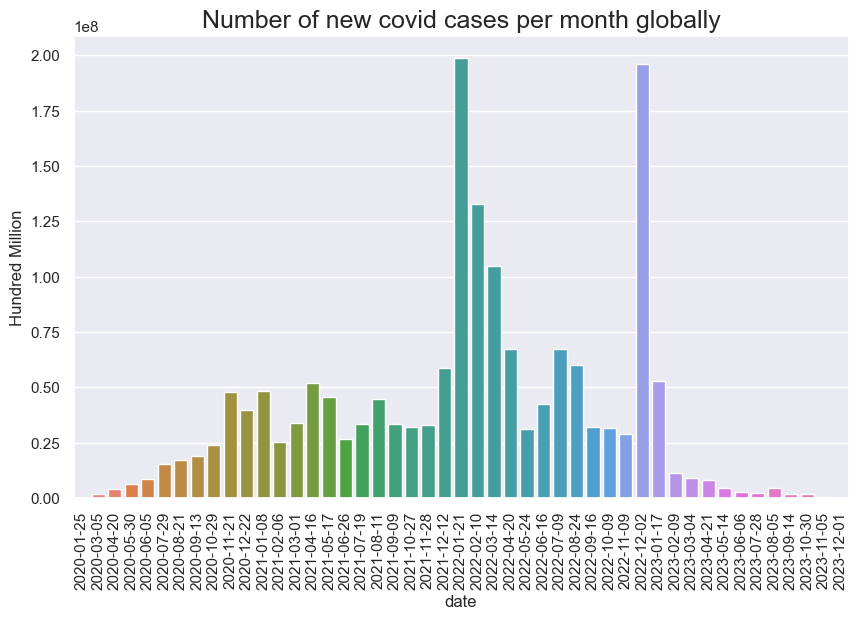

In [310]:
plt.figure(figsize=(10,6))

sns.barplot(data=global_grouped, x='date', y='new_cases_per_day', label='Daily Cases', hue='date')
plt.xticks(rotation=90)
plt.title('Number of new covid cases per month globally', size=18)
plt.ylabel('Hundred Million')
plt.show()